## A. Kevin's NLTK NLP Text Analytics Pipeline V1

### 1.00 Installing Libraries and Dependencies

python 3.11
libraries needed:
nltk
pandas
numpy


conda update -n base -c conda-forge conda
conda create -n nltk-env python=3.11
conda activate nltk-env
conda install ipykernel nltk pandas numpy plotly matplotlib ipywidgets openpyxl -c conda-forge
pip install spacy
python -m spacy download en_core_web_sm
python -m spacy download en_core_web_trf

In [ ]:
%pip install --upgrade nltk
%pip install --upgrade pandas
%pip install --upgrade numpy
%pip install --upgrade plotly
%pip install --upgrade matplotlib
%pip install --upgrade jupyter ipywidgets

In [66]:
%pip install nbformat --upgrade


Note: you may need to restart the kernel to use updated packages.


In [67]:
%pip install ipython --upgrade


Note: you may need to restart the kernel to use updated packages.


### 1.01 NLTK Preprocessing and tokenization for Peeking under the Hood Text Analytics

Running the code cell below will result in us pulling the following token types for each of our seven corpora.
1. word tokens - formed from decomposing sentences into their constituent pieces.
2. NLTK text objects - The NLTK library has a unique tokenizer that adds additional metadata to the word token which allows for unique analysis as compared to normal word tokens.
3. original sentence tokens - based on numerous features, but normally bounded by punctuation marks. This is why we normally tokenize this first before other text processing.
4. normalized sentence tokens - original sentence tokens that have been lowercased, and had stop words, punctuations, and special chracters removed.

You can always figure out what type of data corpus you are dealing with by running these print checks. It is also extremely important to also note the importance of keeping your documents categorized, lest they get out of control. The more processing and feature extractions you do, the more you may end up with more different buckets of data to keep up with.
* We will look at the utility of each token type in these modules

CSV to corpus
folder_path = 'data/outputFiles/csvOutputs/diarizedTranscripts'

## New code

1. needs 3.10 or 3.11 for spacy 
2. conda install ipykernel pandas numpy nltk spacy sentence-transformers scikit-learn
3. python -m spacy download en_core_web_sm

In [ ]:
%pip install textblob

##Start pipeline

In [2]:
import os
import glob
import pandas as pd
import spacy
import nltk
from nltk.corpus import stopwords
import re
from textblob import TextBlob  # For sentiment analysis (optional)

# Load SpaCy model for preprocessing and analysis (en_core_web_sm for English)
nlp = spacy.load('en_core_web_sm')

# Download NLTK stopwords and tokenizers
nltk.download('stopwords')
nltk.download('punkt')  # For sentence and word tokenization
stop_words = set(stopwords.words('english'))

# 1. Function to read CSV files from a folder and its subfolders
def read_transcripts_from_folder(base_dir):
    csv_files = glob.glob(os.path.join(base_dir, '**/*.csv'), recursive=True)
    transcripts = []
    for file in csv_files:
        df = pd.read_csv(file)
        transcripts.append(df)
    return transcripts

# 2. Text preprocessing with SpaCy (no stopword removal yet)
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize the text using SpaCy
    doc = nlp(text)
    
    # Lemmatize and remove punctuation, no stopword removal yet
    tokens = [token.lemma_ for token in doc if not token.is_punct]
    
    return ' '.join(tokens)

# 3. SpaCy POS, NER, and Dependency parsing analysis
def spacy_analysis(text):
    doc = nlp(text)
    pos_tags = [(token.text, token.pos_) for token in doc]  # Part-of-speech tagging
    entities = [(ent.text, ent.label_) for ent in doc.ents]  # Named entity recognition
    dependencies = [(token.text, token.dep_, token.head.text) for token in doc]  # Dependency parsing
    return pos_tags, entities, dependencies

# 4. Sentiment analysis using TextBlob
def sentiment_analysis(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity  # Sentiment polarity and subjectivity

# 5. NLTK tokenization and text object creation
def nltk_tokenization_and_text_object(df):
    # Sentence tokens of unprocessed and processed text
    df['nltk_unprocessed_sentence_tokens'] = df['text'].apply(nltk.sent_tokenize)  # Unprocessed sentence tokens
    df['nltk_processed_sentence_tokens'] = df['cleaned_text'].apply(nltk.sent_tokenize)  # Processed sentence tokens
    
    # Word tokens of unprocessed and processed text
    df['nltk_unprocessed_word_tokens'] = df['text'].apply(nltk.word_tokenize)  # Unprocessed word tokens
    df['nltk_processed_word_tokens'] = df['cleaned_text'].apply(nltk.word_tokenize)  # Processed word tokens
    
    # NLTK Text object for processed text
    df['nltk_text_object'] = df['nltk_unprocessed_word_tokens'].apply(nltk.Text)  # NLTK Text object for processed text
    
    return df

# 6. Apply preprocessing and analysis to the 'text' column of each CSV
def preprocess_and_analyze_transcripts(transcripts):
    results = []
    
    for df in transcripts:
        df['cleaned_text'] = df['text'].apply(preprocess_text)  # Preprocess the text
        
        # Apply SpaCy analysis (POS tags, NER, Dependency parsing)
        df['pos_tags'], df['entities'], df['dependencies'] = zip(*df['text'].apply(spacy_analysis))
        
        # Word count and sentence length
        df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
        df['sentence_length'] = df['text'].apply(lambda x: len(x.split()))  # Original text sentence length
        
        # Sentiment analysis (polarity and subjectivity)
        df['sentiment_polarity'], df['sentiment_subjectivity'] = zip(*df['text'].apply(sentiment_analysis))
        
        # Apply NLTK tokenization and text object creation
        df = nltk_tokenization_and_text_object(df)
        
        results.append(df)
    
    return results

# 7. Main pipeline function to process CSV files
def process_csv_files(base_dir):
    # Step 1: Read all transcripts from the CSV files
    transcripts = read_transcripts_from_folder(base_dir)
    
    # Step 2: Preprocess and analyze the transcripts
    processed_transcripts = preprocess_and_analyze_transcripts(transcripts)
    
    return processed_transcripts

# Example usage of the pipeline
base_dir = 'data/Interviews'  # Folder containing the CSV transcript files
output_dir = 'data/Processed'  # Folder to save the processed CSV files

# Ensure the output directory exists (create it if it doesn't)
os.makedirs(output_dir, exist_ok=True)

# Process the CSV files
processed_transcripts = process_csv_files(base_dir)

# Save the processed CSV files with reordered columns
for i, df in enumerate(processed_transcripts):
    # Define the desired column order
    column_order = ['sentence_number', 'speaker', 'cleaned_text', 'entities', 'word_count', 'sentence_length', 
                    'sentiment_polarity', 'sentiment_subjectivity', 'nltk_unprocessed_sentence_tokens', 
                    'nltk_processed_sentence_tokens', 'nltk_unprocessed_word_tokens', 'nltk_processed_word_tokens', 
                    'nltk_text_object', 'pos_tags', 'dependencies']
    
    # Save the DataFrame with reordered columns
    df[column_order].to_csv(os.path.join(output_dir, f'processed_transcript_{i}.csv'), index=False)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kevinhall/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kevinhall/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Checking the dataframes

In [18]:
# Print the first 10 rows of the first processed transcript
print(processed_transcripts[1].head(10))


    start     end                                               text  \
0   3.015   6.157   Okay, all right, so yeah, we're being recorde...   
1   6.177  10.220  All right, so some of these early ones are bas...   
2  10.280  13.422  And so the first one is really just a very gen...   
3  13.943  16.745  So what do you teach here as far as subject an...   
4  16.765  21.308  And also then attach to that, are you involved...   
5  23.269  30.875  This upcoming year, I am teaching freshman co-...   
6  31.670  35.533                      AP biology, and food science.   
7  36.193  38.214            So yeah, this will be a four prep year.   
8  38.995  44.779  And then outside of that, I coach cross countr...   
9  47.460  47.841                                           Oh, wow.   

                                               words     speaker  \
0  [{'word': 'Okay,', 'start': 3.015, 'end': 3.45...  SPEAKER_01   
1  [{'word': 'All', 'start': 6.177, 'end': 6.237,...  SPEAKER_01   
2  

## Old need to fix

## 2.00 Peeking Under The Hood Text Analytics 

### 2.01 Average Sentence Length
Average Sentence Length uses the total number of words and total number of sentences
in a corpus to calculate exactly what it says: the average sentence length.
While the equation is very basic and straightforward it provides information that can
be used to infer, for example, how complex sentences are on average throughout a
given text corpus.

In [19]:
# 1. Function to calculate and print metrics (sentence and word count, average sentence length)
def calculate_metrics(processed_transcripts):
    for i, df in enumerate(processed_transcripts):
        # Retrieve sentence and word tokens from the DataFrame
        sentence_tokens = df['nltk_unprocessed_sentence_tokens'].explode().tolist()  # Flatten the sentence tokens
        word_tokens = df['nltk_unprocessed_word_tokens'].explode().tolist()  # Flatten the word tokens

        # Ensure there are sentences to avoid division by zero
        if sentence_tokens:
            average_sentence_length = len(word_tokens) / len(sentence_tokens)
        else:
            average_sentence_length = 0  # Default to zero if no sentences

        # Print results for each transcript
        print(f"\nTranscript {i + 1}:")
        print("Number of sentences:", len(sentence_tokens))
        print("Number of word tokens:", len(word_tokens))
        print("Average sentence length:", average_sentence_length)

# 2. Run the metric calculation on the processed transcripts
calculate_metrics(processed_transcripts)



Transcript 1:
Number of sentences: 1330
Number of word tokens: 20998
Average sentence length: 15.78796992481203

Transcript 2:
Number of sentences: 545
Number of word tokens: 8650
Average sentence length: 15.871559633027523

Transcript 3:
Number of sentences: 663
Number of word tokens: 9991
Average sentence length: 15.069381598793363

Transcript 4:
Number of sentences: 860
Number of word tokens: 14700
Average sentence length: 17.093023255813954

Transcript 5:
Number of sentences: 594
Number of word tokens: 10698
Average sentence length: 18.01010101010101

Transcript 6:
Number of sentences: 570
Number of word tokens: 8019
Average sentence length: 14.06842105263158

Transcript 7:
Number of sentences: 516
Number of word tokens: 8039
Average sentence length: 15.579457364341085


### 2.02 Average Word Length Distribution
Another fairly straightforward measure that can provide insight into how long, on average, words are in a given corpus.

In [21]:
# 1. Function to calculate and print average word length for each transcript
def calculate_avg_word_length(processed_transcripts):
    for i, df in enumerate(processed_transcripts):
        # Retrieve word tokens from the DataFrame (unprocessed word tokens)
        word_tokens = df['nltk_unprocessed_word_tokens'].explode().tolist()  # Flatten the word tokens

        # Calculate the average word length if there are word tokens
        if word_tokens:
            avg_word_length = sum(len(word) for word in word_tokens) / len(word_tokens)
        else:
            avg_word_length = 0  # Default to zero if no word tokens

        # Print results for each transcript
        print(f"\nTranscript {i + 1}:")
        print("Number of word tokens:", len(word_tokens))
        print("Average word length:", avg_word_length)

# 2. Run the average word length calculation on the processed transcripts
calculate_avg_word_length(processed_transcripts)





Transcript 1:
Number of word tokens: 20998
Average word length: 3.5860558148395083

Transcript 2:
Number of word tokens: 8650
Average word length: 3.6660115606936414

Transcript 3:
Number of word tokens: 9991
Average word length: 3.4157741967770994

Transcript 4:
Number of word tokens: 14700
Average word length: 3.5326530612244897

Transcript 5:
Number of word tokens: 10698
Average word length: 3.6013273509067116

Transcript 6:
Number of word tokens: 8019
Average word length: 3.531986531986532

Transcript 7:
Number of word tokens: 8039
Average word length: 3.5590247543226767


### 2.03 Lexical Diversity
Lexical diversity quantifies the variety of unique words found in a document. It produces a numerical measure that indicates how diverse the vocabulary is that is used in a text. Broadly speaking, scores of (0.8 - 1) are considered extremely high and difficult to maintain in typical communicative texts. Scores of 0.4-0.79 are considered moderate to high; most high-quality texts fall in this range. Scores of (0 - 0.39) are considered low lexical diversity and tend to suggest highly specialized or technical language usage (e.g., instruction manuals) or language aimed at young readers. This measure is sensitive to corpus length (longer corpora have more opportunities to repeat words), but comparing lexical diversity scores can allow for quantitative comparison that might suggest potential changes in how the usage of language may differ between groups.

In [22]:
# 1. Function to calculate and print lexical diversity for each transcript
def calculate_lexical_diversity(processed_transcripts):
    for i, df in enumerate(processed_transcripts):
        # Retrieve word tokens from the DataFrame (unprocessed word tokens)
        word_tokens = df['nltk_unprocessed_word_tokens'].explode().tolist()  # Flatten the word tokens

        # Calculate the lexical diversity if there are word tokens
        if word_tokens:
            lexical_diversity = len(set(word_tokens)) / len(word_tokens)  # Unique words divided by total words
        else:
            lexical_diversity = 0  # Default to zero if no word tokens

        # Print results for each transcript
        print(f"\nTranscript {i + 1}:")
        print("Number of word tokens:", len(word_tokens))
        print("Lexical diversity:", lexical_diversity)

# 2. Run the lexical diversity calculation on the processed transcripts
calculate_lexical_diversity(processed_transcripts)





Transcript 1:
Number of word tokens: 20998
Lexical diversity: 0.08600819125631012

Transcript 2:
Number of word tokens: 8650
Lexical diversity: 0.12971098265895953

Transcript 3:
Number of word tokens: 9991
Lexical diversity: 0.10009008107296567

Transcript 4:
Number of word tokens: 14700
Lexical diversity: 0.09068027210884354

Transcript 5:
Number of word tokens: 10698
Lexical diversity: 0.09627967844456908

Transcript 6:
Number of word tokens: 8019
Lexical diversity: 0.11447811447811448

Transcript 7:
Number of word tokens: 8039
Lexical diversity: 0.1270058464983207


### 2.04 Unique Words Over Time
Unique words can be used to identify the frequency of words that appear only once in a given corpus. We can also print a list of these word tokens. Looking at unique words between or across text corpora can allow us to look for the appearances and disappearances of specialized educational terminology over time. To find the frequency (number) of unique words, use the following code:

In [23]:
# 1. Function to calculate and print the number of unique words for each transcript
def calculate_unique_words(processed_transcripts):
    for i, df in enumerate(processed_transcripts):
        # Retrieve word tokens from the DataFrame (unprocessed word tokens)
        word_tokens = df['nltk_unprocessed_word_tokens'].explode().tolist()  # Flatten the word tokens

        # Calculate the number of unique words
        unique_words = set(word_tokens)
        unique_word_count = len(unique_words)

        # Print results for each transcript
        print(f"\nTranscript {i + 1}:")
        print("Number of unique words:", unique_word_count)

# 2. Run the unique word count calculation on the processed transcripts
calculate_unique_words(processed_transcripts)





Transcript 1:
Number of unique words: 1806

Transcript 2:
Number of unique words: 1122

Transcript 3:
Number of unique words: 1000

Transcript 4:
Number of unique words: 1333

Transcript 5:
Number of unique words: 1030

Transcript 6:
Number of unique words: 918

Transcript 7:
Number of unique words: 1021


### 2.05 Twenty-Five Most Frequent Words

In [24]:
import nltk

# 1. Function to calculate and print the top 25 most common words for each transcript
def calculate_most_common_words(processed_transcripts, top_n=25):
    for i, df in enumerate(processed_transcripts):
        # Retrieve the NLTK text object from the DataFrame (which is based on unprocessed word tokens)
        text_objects = df['nltk_text_object'].values

        # Check if text_objects exist and are not empty
        if len(text_objects) > 0:
            # Generate a frequency distribution for the text objects (word tokens)
            freq_dist = nltk.FreqDist([word for text_obj in text_objects for word in text_obj])

            # Get the top N most common words
            most_common_words = freq_dist.most_common(top_n)

            # Print results for each transcript
            print(f"\nMost common words in Transcript {i + 1}:")
            print(most_common_words)
        else:
            print(f"No text objects available for Transcript {i + 1}")

# 2. Run the frequency distribution calculation on the processed transcripts
calculate_most_common_words(processed_transcripts)




Most common words in Transcript 1:
[(',', 1508), ('.', 965), ('I', 864), ('that', 590), ('to', 578), ('like', 393), ('the', 392), ('a', 382), ('of', 371), ('and', 345), ("'s", 343), ('you', 337), ('it', 323), ('in', 243), ('think', 239), ('?', 227), ('know', 225), ('And', 199), ('we', 194), ('do', 193), ('right', 163), ("n't", 161), ('about', 159), ('is', 152), ('they', 148)]

Most common words in Transcript 2:
[(',', 601), ('.', 405), ('that', 297), ('I', 273), ('the', 225), ('to', 202), ('you', 181), ('like', 152), ('and', 141), ('of', 138), ('it', 126), ("'s", 121), ('we', 117), ('And', 116), ('a', 107), ('know', 87), ('?', 86), ('just', 82), ('is', 80), ('was', 80), ('what', 77), ('in', 77), ('this', 76), ('So', 68), ('do', 68)]

Most common words in Transcript 3:
[(',', 909), ('.', 533), ('I', 368), ('like', 323), ('to', 240), ('it', 234), ('that', 210), ('you', 208), ('the', 192), ('and', 188), ('a', 140), ('of', 130), ('we', 124), ('they', 118), ('was', 115), ("'s", 112), ('And

### 2.06 Display all unique words found in a corpus

In [25]:
# 1. Create a dictionary where each key is the transcript index and value is a set of word tokens
corpora_tokens = {
    f'Transcript {i + 1}': set(df['nltk_unprocessed_word_tokens'].explode().tolist())
    for i, df in enumerate(processed_transcripts)
}

# 2. Function to find words unique to each transcript compared to others
def find_unique_words(corpora_tokens):
    unique_words = {}
    for corpus_name, tokens in corpora_tokens.items():
        # Start with the current transcript's tokens
        all_other_tokens = set()
        for other_corpus_name, other_tokens in corpora_tokens.items():
            if corpus_name != other_corpus_name:
                all_other_tokens.update(other_tokens)
        
        # Unique words are those not in the union of all other tokens
        unique_words[corpus_name] = tokens - all_other_tokens
    return unique_words

# 3. Find words unique to each transcript
unique_words_by_transcript = find_unique_words(corpora_tokens)

# 4. Print unique words for each transcript
for transcript_name, unique_words in unique_words_by_transcript.items():
    print(f"Words exclusive to {transcript_name}:", sorted(unique_words))



Words exclusive to Transcript 1: ['&', "''", '20-minute', '23-minute', '26', '40', '9', 'AMA', 'AMTA', 'Ability', 'Add', 'Additionally', 'After', 'Again', 'Agree', 'Allstate', 'Although', 'American', 'Andrew', 'Arctic', 'Association', 'August', 'Best', 'Bio', 'Biology', 'Cafe', 'Canada', 'Champagne', 'Chem', 'ChemPhys', 'Circle', 'Co', 'Colorado', 'Could', 'Crane', 'Curricula', 'DNA', 'Daniel', 'DoorDash', 'Doyle', 'EdWebs', 'End', 'Environmental', 'Feel', 'Figuring', 'Fingers', 'Fs', 'GEMS', 'Getting', 'God', 'Heck', 'IAP', 'Indiana', 'Inherently', 'Kate', 'Kemp', 'Learning', 'Literally', 'Logan', 'Love', 'MGSS', 'Master', 'Materials', 'Migget', 'Might', 'Morales', 'Morales-Doyle', 'Neuron', 'New', 'Next', 'Of', 'On', 'Only', 'OpenSciAD', 'Orgo', 'Phys', 'Planning', 'Plant', 'Project', 'R18', 'RNA', 'Rambling', 'Reasons', 'Recently', 'Since', 'Society', 'Something', 'Stay', 'Steena', 'Students', 'Switched', 'Violet', 'Waves', 'Who', 'Without', 'Work', 'Working', 'Worksheet', 'Writing'

### 2.07 Most frequently used words across all corpora:

In [26]:
from collections import Counter
import nltk

# 1. Aggregate all word tokens from all transcripts into a single list
all_tokens = []
for df in processed_transcripts:
    word_tokens = df['nltk_unprocessed_word_tokens'].explode().tolist()  # Flatten the word tokens
    all_tokens.extend(word_tokens)

# 2. Calculate the frequency distribution of all tokens
token_freq_dist = Counter(all_tokens)

# 3. Find the most common words across all transcripts (adjust the number as needed)
most_common_words = token_freq_dist.most_common(100)

# 4. Function to print data in columns
def print_in_columns(data, columns=3):
    # Split the data into chunks of size 'columns'
    for i in range(0, len(data), columns):
        chunk = data[i:i + columns]
        # Format and print each chunk
        print("  ".join(f"{word}: {freq}" for word, freq in chunk))

# 5. Print the most common words in columns
print("Most frequently used words across all transcripts:")
print_in_columns(most_common_words, columns=1)



Most frequently used words across all transcripts:
,: 6058
.: 3929
I: 2802
that: 2142
to: 2067
like: 1847
the: 1828
you: 1573
and: 1493
of: 1472
it: 1408
a: 1279
's: 1089
we: 860
And: 829
in: 824
know: 785
do: 764
they: 678
?: 658
was: 647
just: 632
n't: 594
So: 583
is: 574
what: 560
think: 555
have: 543
this: 532
're: 522
so: 462
about: 443
with: 443
for: 436
kind: 424
or: 414
but: 403
be: 402
then: 398
really: 393
not: 374
Yeah: 363
on: 354
'm: 354
them: 354
things: 338
are: 312
as: 309
more: 308
students: 300
at: 292
going: 284
did: 275
right: 274
there: 267
my: 260
've: 247
if: 244
yeah: 243
can: 242
all: 241
how: 240
get: 232
were: 232
some: 229
because: 226
year: 217
me: 212
science: 211
had: 211
one: 206
out: 199
would: 199
lot: 199
their: 192
Okay: 187
where: 186
want: 183
your: 178
something: 174
school: 172
when: 168
But: 167
It: 156
our: 155
doing: 152
been: 152
from: 151
up: 149
go: 140
Like: 140
unit: 140
um: 138
into: 137
now: 135
those: 135
You: 134
Um: 133
little: 132
o

### 2.08 N-grams and collocations
N-grams point out recurring word combinations found throughout the text corpus. For example, "spring break" is an example of a bigrams while "New York City" is a trigrams. Bigrams and repeated collocations of words convey a lot of information about the contents of the text corpus.
To generate an ordered list of the most common bigrams, use the following code:

In [27]:
import nltk
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
import pandas as pd
import os

# Set the output directory for n-gram frequencies
output_directory = 'data/outputFiles/ngramFrequencies'
os.makedirs(output_directory, exist_ok=True)  # Ensure the output directory exists

# 1. Loop through each transcript and find bigrams and trigrams
for i, df in enumerate(processed_transcripts):
    # Retrieve word tokens from the DataFrame (unprocessed word tokens)
    word_tokens = df['nltk_unprocessed_word_tokens'].explode().tolist()  # Flatten the word tokens
    
    # Find bigrams
    bigram_finder = BigramCollocationFinder.from_words(word_tokens)
    bigrams = bigram_finder.ngram_fd.items()
    bigrams_sorted = sorted(bigrams, key=lambda item: item[1], reverse=True)
    bigram_df = pd.DataFrame(bigrams_sorted, columns=['Bigram', 'Frequency'])
    
    # Save bigrams to CSV
    bigram_filename = os.path.join(output_directory, f"transcript_{i + 1}_bigrams.csv")
    bigram_df.to_csv(bigram_filename, index=False)
    print(f"Top 50 bigrams for Transcript {i + 1} saved to {bigram_filename}")
    
    # Find trigrams
    trigram_finder = TrigramCollocationFinder.from_words(word_tokens)
    trigrams = trigram_finder.ngram_fd.items()
    trigrams_sorted = sorted(trigrams, key=lambda item: item[1], reverse=True)
    trigram_df = pd.DataFrame(trigrams_sorted, columns=['Trigram', 'Frequency'])
    
    # Save trigrams to CSV
    trigram_filename = os.path.join(output_directory, f"transcript_{i + 1}_trigrams.csv")
    trigram_df.to_csv(trigram_filename, index=False)
    print(f"Top 50 trigrams for Transcript {i + 1} saved to {trigram_filename}")

    print("\n")


Top 50 bigrams for Transcript 1 saved to data/outputFiles/ngramFrequencies/transcript_1_bigrams.csv
Top 50 trigrams for Transcript 1 saved to data/outputFiles/ngramFrequencies/transcript_1_trigrams.csv


Top 50 bigrams for Transcript 2 saved to data/outputFiles/ngramFrequencies/transcript_2_bigrams.csv
Top 50 trigrams for Transcript 2 saved to data/outputFiles/ngramFrequencies/transcript_2_trigrams.csv


Top 50 bigrams for Transcript 3 saved to data/outputFiles/ngramFrequencies/transcript_3_bigrams.csv
Top 50 trigrams for Transcript 3 saved to data/outputFiles/ngramFrequencies/transcript_3_trigrams.csv


Top 50 bigrams for Transcript 4 saved to data/outputFiles/ngramFrequencies/transcript_4_bigrams.csv
Top 50 trigrams for Transcript 4 saved to data/outputFiles/ngramFrequencies/transcript_4_trigrams.csv


Top 50 bigrams for Transcript 5 saved to data/outputFiles/ngramFrequencies/transcript_5_bigrams.csv
Top 50 trigrams for Transcript 5 saved to data/outputFiles/ngramFrequencies/transcri

In [28]:
import nltk
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder

# 1. Loop through each transcript to find and display top bigrams and trigrams
for i, df in enumerate(processed_transcripts):
    # Retrieve word tokens from the DataFrame (unprocessed word tokens)
    word_tokens = df['nltk_unprocessed_word_tokens'].explode().tolist()  # Flatten the word tokens
    
    # Display frequency of highest 50 bigrams
    print(f"Top 50 bigrams for Transcript {i + 1}:")
    bigram_finder = BigramCollocationFinder.from_words(word_tokens)
    bigram_finder.ngram_fd.tabulate(50)  # Display top 50 bigrams
    
    # Display frequency of highest 50 trigrams
    print(f"Top 50 trigrams for Transcript {i + 1}:")
    trigram_finder = TrigramCollocationFinder.from_words(word_tokens)
    trigram_finder.ngram_fd.tabulate(50)  # Display top 50 trigrams
    
    print("\n")


Top 50 bigrams for Transcript 1:
       (',', 'I')    ('I', 'think')     ('like', ',')      ('.', 'And')        ('.', 'I')       ('I', "'m")    (',', 'right')      ('it', "'s")      (',', 'you')   ('you', 'know')     ('know', ',')     ('do', "n't")    ('right', '?')     ('.', 'Yeah')   ('going', 'to')     (',', 'like') ('think', 'that')      (',', 'and')       ('I', 'do')       ('.', 'So')      ('a', 'lot')    ('that', "'s")      (',', 'but')     ('Yeah', '.')     ('that', 'I')     ('I', 'mean')   ('You', 'know')     ('in', 'the')      ('And', 'I')     ('what', 'I')     ('we', "'re")    ('kind', 'of')     ('of', 'the')     ('Yeah', ',')    ('sort', 'of')     ('lot', 'of')      ('.', 'You')     ('that', '.')  ('know', 'what')       (',', 'it')    ('you', "'re")      ('to', 'be')      ('and', 'I')      ('I', 'was')       ("'s", 'a')      ('I', "'ve")      ('to', 'do')     ('that', ',')    ("'s", 'like')    ('want', 'to') 
              195               185               170             

### 2.09 Concordance
Concordance is an NLTK Text object method that also looks for word distribution, but specifically searches for words found before and after a specific word of choice. Concordance allows us to find out how words are used contextually throughout a corpus. This can be particularly powerful when looking at trends over time or between groups. For example, in the sample below we search for the all the contextual occurrences of the word “pi” in our seven separate corpora.

In [47]:
import os
import pandas as pd
import nltk

# Ensure NLTK data files are downloaded
nltk.download('punkt')  # For word_tokenize

# Specify the folder path where CSV files are stored
folder_path = 'data/Interviews/'  # Replace with your actual folder path

# Dictionary to store NLTK Text objects for each transcript
nltk_texts = {}

# Function to read CSV files from a folder and its subfolders
def read_transcripts_from_folder(base_dir):
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                # Read the CSV file into a pandas DataFrame
                df = pd.read_csv(file_path)
                
                # Check if 'text' column exists
                if 'text' in df.columns:
                    # Combine all text data into a single string
                    text_data = ' '.join(df['text'].dropna().astype(str))
                    # Tokenize the text data
                    tokens = nltk.word_tokenize(text_data)
                    # Create an NLTK Text object
                    text_object = nltk.Text(tokens)
                    # Store the Text object in the dictionary with the file path as the key
                    nltk_texts[file_path] = text_object
                else:
                    print(f"'text' column not found in {file_path}")

# Process the transcripts and create NLTK Text objects
read_transcripts_from_folder(folder_path)

# Example: Use concordance method to find occurrences of a word across all texts
word_to_search = 'equity'  # Replace with the word you want to search

for file_path, text_obj in nltk_texts.items():
    print(f"Concordance for '{word_to_search}' in {file_path}:")
    text_obj.concordance(word_to_search, width=150)
    print("\n")



[nltk_data] Downloading package punkt to /Users/kevinhall/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Concordance for 'equity' in data/Interviews/20240522_INT_HS_UT_Steffan/20240522_INT_HS_UT_Steffan_2024-08-07_transcription.csv:
Displaying 4 of 4 matches:
 I 'm going to say equitable , because I also think that we have a huge equity issue right now in education , in that I do n't think that we are expec
ut of them and not teaching them as in-depth a content amount is a huge equity issue . You know what I mean ? Like if we 're not , if we 're teaching 
ink it 's often done in the name of , in sort of falsely in the name of equity , you know what I mean ? Like , I think that there 's a lot of linguist
ot by saying we 're not going to read because I think that gets to that equity issue and exacerbates our problem , right ? Like we need our students t


Concordance for 'equity' in data/Interviews/20240612_INT_HS_Charles/20240612_INT_HS_Charles_2024-08-07_transcription.csv:
no matches


Concordance for 'equity' in data/Interviews/20240531_INT_MS_Vera/20240531_INT_MS_Vera_2024-08-07_transcr

# Concordance with Multiple Words:

In [48]:
words_to_search = ['equity', 'students', 'teachers']  # Add more words as needed

for word in words_to_search:
    print(f"\nConcordance for '{word}':")
    for file_path, text_obj in nltk_texts.items():
        print(f"File: {file_path}")
        text_obj.concordance(word, width=150)
        print("\n")



Concordance for 'equity':
File: data/Interviews/20240522_INT_HS_UT_Steffan/20240522_INT_HS_UT_Steffan_2024-08-07_transcription.csv
Displaying 4 of 4 matches:
 I 'm going to say equitable , because I also think that we have a huge equity issue right now in education , in that I do n't think that we are expec
ut of them and not teaching them as in-depth a content amount is a huge equity issue . You know what I mean ? Like if we 're not , if we 're teaching 
ink it 's often done in the name of , in sort of falsely in the name of equity , you know what I mean ? Like , I think that there 's a lot of linguist
ot by saying we 're not going to read because I think that gets to that equity issue and exacerbates our problem , right ? Like we need our students t


File: data/Interviews/20240612_INT_HS_Charles/20240612_INT_HS_Charles_2024-08-07_transcription.csv
no matches


File: data/Interviews/20240531_INT_MS_Vera/20240531_INT_MS_Vera_2024-08-07_transcription.csv
no matches


File: data/Interv

# Collocation Analysis

In [49]:
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder

for file_path, text_obj in nltk_texts.items():
    print(f"Top 10 bigrams for {file_path}:")
    bigram_finder = BigramCollocationFinder.from_words(text_obj)
    bigrams = bigram_finder.ngram_fd.most_common(10)
    print(bigrams)
    
    print(f"Top 10 trigrams for {file_path}:")
    trigram_finder = TrigramCollocationFinder.from_words(text_obj)
    trigrams = trigram_finder.ngram_fd.most_common(10)
    print(trigrams)
    print("\n")


Top 10 bigrams for data/Interviews/20240522_INT_HS_UT_Steffan/20240522_INT_HS_UT_Steffan_2024-08-07_transcription.csv:
[((',', 'I'), 195), (('I', 'think'), 185), (('like', ','), 170), (('.', 'And'), 160), (('.', 'I'), 154), (('I', "'m"), 126), ((',', 'right'), 115), (('it', "'s"), 114), ((',', 'you'), 112), (('you', 'know'), 104)]
Top 10 trigrams for data/Interviews/20240522_INT_HS_UT_Steffan/20240522_INT_HS_UT_Steffan_2024-08-07_transcription.csv:
[((',', 'right', '?'), 91), ((',', 'you', 'know'), 81), (('you', 'know', ','), 78), (('I', 'think', 'that'), 69), (('I', 'do', "n't"), 67), (('.', 'Yeah', '.'), 55), (('a', 'lot', 'of'), 45), ((',', 'like', ','), 45), (('.', 'I', 'think'), 43), (('.', 'And', 'I'), 42)]


Top 10 bigrams for data/Interviews/20240612_INT_HS_Charles/20240612_INT_HS_Charles_2024-08-07_transcription.csv:
[(('.', 'And'), 98), (('.', 'So'), 63), (('like', ','), 56), (('know', ','), 56), ((',', 'I'), 54), ((',', 'you'), 53), (('.', 'I'), 51), (('you', 'know'), 49), (

# Lexical Diversity

In [50]:
for file_path, text_obj in nltk_texts.items():
    total_words = len(text_obj)
    unique_words = len(set(text_obj))
    lexical_diversity = unique_words / total_words if total_words > 0 else 0
    print(f"Lexical diversity for {file_path}: {lexical_diversity:.3f}")


Lexical diversity for data/Interviews/20240522_INT_HS_UT_Steffan/20240522_INT_HS_UT_Steffan_2024-08-07_transcription.csv: 0.086
Lexical diversity for data/Interviews/20240612_INT_HS_Charles/20240612_INT_HS_Charles_2024-08-07_transcription.csv: 0.130
Lexical diversity for data/Interviews/20240531_INT_MS_Vera/20240531_INT_MS_Vera_2024-08-07_transcription.csv: 0.100
Lexical diversity for data/Interviews/20240603_INT_MS_Uma/20240603_INT_MS_Uma_2024-08-07_transcription.csv: 0.091
Lexical diversity for data/Interviews/20240606_INT_MS_Gloria/20240606_INT_MS_Gloria_2024-08-07_transcription.csv: 0.096
Lexical diversity for data/Interviews/20240531_INT_MS_Xander/20240531_INT_MS_Xander_2024-08-07_transcription.csv: 0.115
Lexical diversity for data/Interviews/20240718_INT_HS_Neil/20240718_INT_HS_Neil_2024-08-07_transcription.csv: 0.127


# Frequency Distribution

In [51]:
from nltk.probability import FreqDist

for file_path, text_obj in nltk_texts.items():
    fdist = FreqDist(text_obj)
    print(f"Top 10 most common words in {file_path}:")
    print(fdist.most_common(10))
    print("\n")


Top 10 most common words in data/Interviews/20240522_INT_HS_UT_Steffan/20240522_INT_HS_UT_Steffan_2024-08-07_transcription.csv:
[(',', 1508), ('.', 960), ('I', 863), ('that', 590), ('to', 578), ('like', 393), ('the', 392), ('a', 382), ('of', 371), ('and', 345)]


Top 10 most common words in data/Interviews/20240612_INT_HS_Charles/20240612_INT_HS_Charles_2024-08-07_transcription.csv:
[(',', 601), ('.', 401), ('that', 297), ('I', 273), ('the', 225), ('to', 202), ('you', 181), ('like', 152), ('and', 141), ('of', 138)]


Top 10 most common words in data/Interviews/20240531_INT_MS_Vera/20240531_INT_MS_Vera_2024-08-07_transcription.csv:
[(',', 909), ('.', 524), ('I', 367), ('like', 323), ('to', 240), ('it', 234), ('that', 210), ('you', 208), ('the', 192), ('and', 188)]


Top 10 most common words in data/Interviews/20240603_INT_MS_Uma/20240603_INT_MS_Uma_2024-08-07_transcription.csv:
[(',', 1157), ('.', 700), ('I', 439), ('you', 406), ('to', 396), ('that', 352), ('and', 334), ('the', 327), ('

# Generating Concordance-like Contexts (Similar Words):

In [52]:
for file_path, text_obj in nltk_texts.items():
    print(f"Words similar to 'equity' in {file_path}:")
    text_obj.similar('equity')
    print("\n")


Words similar to 'equity' in data/Interviews/20240522_INT_HS_UT_Steffan/20240522_INT_HS_UT_Steffan_2024-08-07_transcription.csv:
a pd things freedom gives contrived times days siblings progress


Words similar to 'equity' in data/Interviews/20240612_INT_HS_Charles/20240612_INT_HS_Charles_2024-08-07_transcription.csv:
No matches


Words similar to 'equity' in data/Interviews/20240531_INT_MS_Vera/20240531_INT_MS_Vera_2024-08-07_transcription.csv:
No matches


Words similar to 'equity' in data/Interviews/20240603_INT_MS_Uma/20240603_INT_MS_Uma_2024-08-07_transcription.csv:
No matches


Words similar to 'equity' in data/Interviews/20240606_INT_MS_Gloria/20240606_INT_MS_Gloria_2024-08-07_transcription.csv:
teaching though speed adaptation


Words similar to 'equity' in data/Interviews/20240531_INT_MS_Xander/20240531_INT_MS_Xander_2024-08-07_transcription.csv:
or


Words similar to 'equity' in data/Interviews/20240718_INT_HS_Neil/20240718_INT_HS_Neil_2024-08-07_transcription.csv:
No matches


# 6. Context Dispersion Plot:

Dispersion plot for data/Interviews/20240522_INT_HS_UT_Steffan/20240522_INT_HS_UT_Steffan_2024-08-07_transcription.csv:


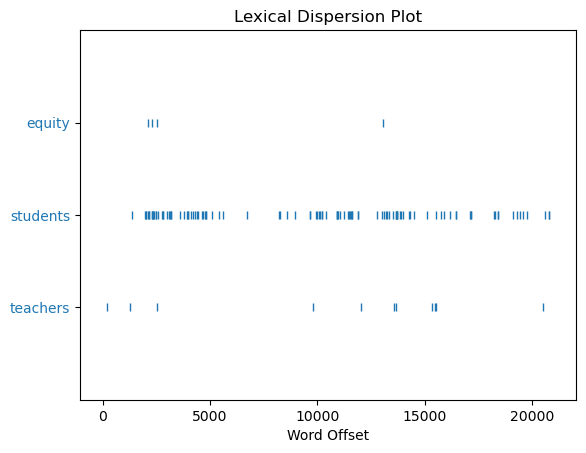

Dispersion plot for data/Interviews/20240612_INT_HS_Charles/20240612_INT_HS_Charles_2024-08-07_transcription.csv:


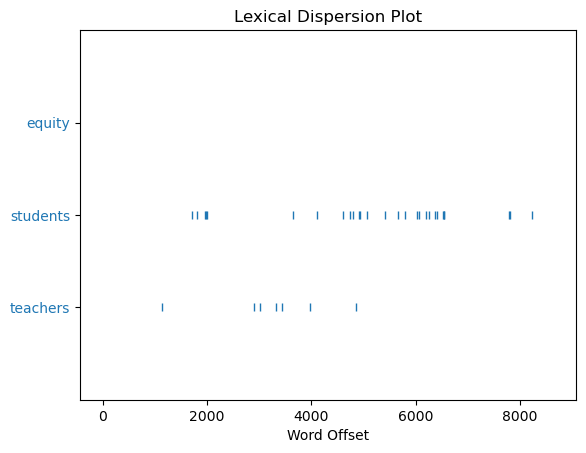

Dispersion plot for data/Interviews/20240531_INT_MS_Vera/20240531_INT_MS_Vera_2024-08-07_transcription.csv:


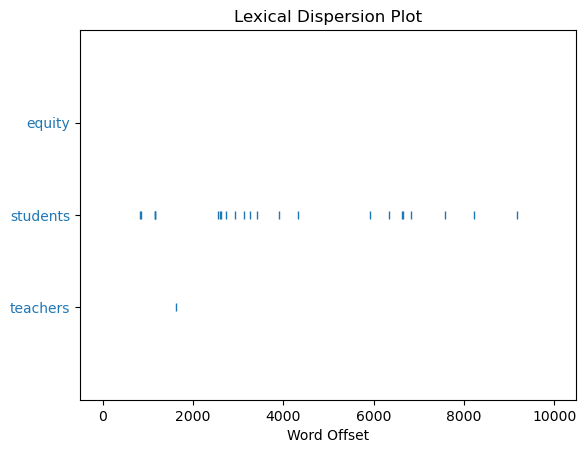

Dispersion plot for data/Interviews/20240603_INT_MS_Uma/20240603_INT_MS_Uma_2024-08-07_transcription.csv:


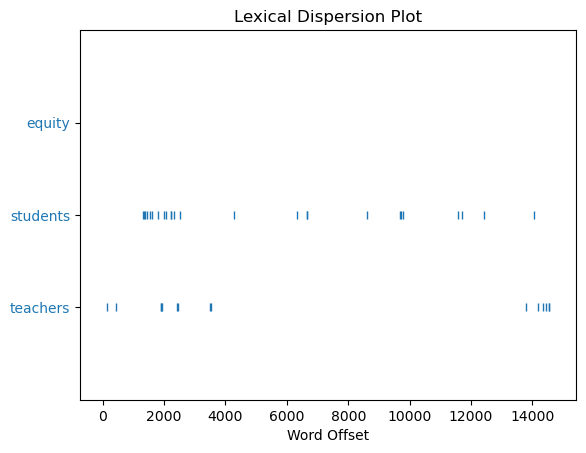

Dispersion plot for data/Interviews/20240606_INT_MS_Gloria/20240606_INT_MS_Gloria_2024-08-07_transcription.csv:


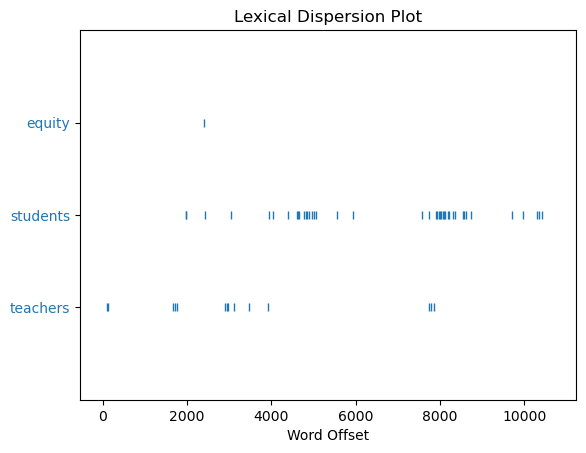

Dispersion plot for data/Interviews/20240531_INT_MS_Xander/20240531_INT_MS_Xander_2024-08-07_transcription.csv:


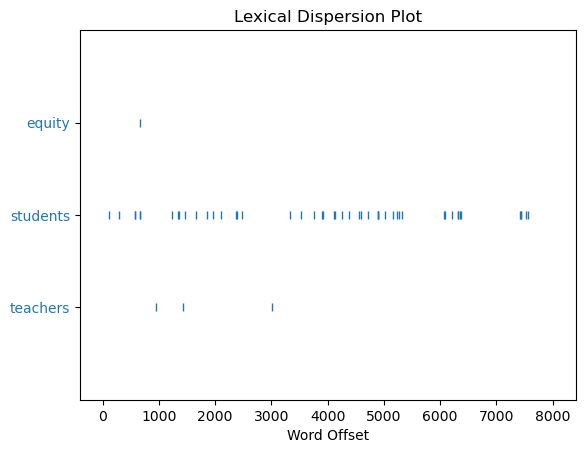

Dispersion plot for data/Interviews/20240718_INT_HS_Neil/20240718_INT_HS_Neil_2024-08-07_transcription.csv:


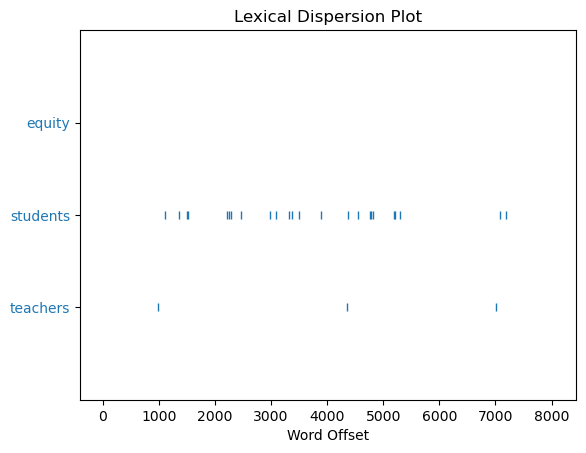

In [53]:
import matplotlib.pyplot as plt

words_to_track = ['equity', 'students', 'teachers']  # Add the words you want to track

for file_path, text_obj in nltk_texts.items():
    print(f"Dispersion plot for {file_path}:")
    text_obj.dispersion_plot(words_to_track)
    plt.show()  # Show the plot for each file


# 7. Word Concordance Similarity:
You can compare concordances of different words to see which words appear in similar contexts. This can help in finding patterns of usage between related terms.

In [55]:
word1 = 'equity'
word2 = 'diversity'
for file_path, text_obj in nltk_texts.items():
    print(f"Similar contexts for '{word1}' and '{word2}' in {file_path}:")
    text_obj.common_contexts([word1, word2])
    print("\n")


Similar contexts for 'equity' and 'diversity' in data/Interviews/20240522_INT_HS_UT_Steffan/20240522_INT_HS_UT_Steffan_2024-08-07_transcription.csv:
No common contexts were found


Similar contexts for 'equity' and 'diversity' in data/Interviews/20240612_INT_HS_Charles/20240612_INT_HS_Charles_2024-08-07_transcription.csv:
('The following word(s) were not found:', 'equity diversity')


Similar contexts for 'equity' and 'diversity' in data/Interviews/20240531_INT_MS_Vera/20240531_INT_MS_Vera_2024-08-07_transcription.csv:
('The following word(s) were not found:', 'equity diversity')


Similar contexts for 'equity' and 'diversity' in data/Interviews/20240603_INT_MS_Uma/20240603_INT_MS_Uma_2024-08-07_transcription.csv:
('The following word(s) were not found:', 'equity diversity')


Similar contexts for 'equity' and 'diversity' in data/Interviews/20240606_INT_MS_Gloria/20240606_INT_MS_Gloria_2024-08-07_transcription.csv:
('The following word(s) were not found:', 'equity diversity')


Similar

# 8. Named Entity Recognition (NER):

In [62]:
import nltk
# Download the averaged_perceptron_tagger for POS tagging
nltk.download('averaged_perceptron_tagger')

# Also, download the necessary NER chunker (if needed)
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk import ne_chunk, pos_tag
from nltk.tokenize import word_tokenize

def extract_named_entities(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    named_entities = ne_chunk(pos_tags)
    return named_entities

for file_path, text_obj in nltk_texts.items():
    text = ' '.join(text_obj)  # Convert NLTK Text object back to string for NER
    print(f"Named entities in {file_path}:")
    named_entities = extract_named_entities(text)
    print(named_entities)
    print("\n")


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/kevinhall/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/kevinhall/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/kevinhall/nltk_data...
[nltk_data]   Package words is already up-to-date!


Named entities in data/Interviews/20240522_INT_HS_UT_Steffan/20240522_INT_HS_UT_Steffan_2024-08-07_transcription.csv:


LookupError: 
**********************************************************************
  Resource [93mmaxent_ne_chunker_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('maxent_ne_chunker_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mchunkers/maxent_ne_chunker_tab/english_ace_multiclass/[0m

  Searched in:
    - '/Users/kevinhall/nltk_data'
    - '/opt/homebrew/Caskroom/miniforge/base/envs/nlp24-env/nltk_data'
    - '/opt/homebrew/Caskroom/miniforge/base/envs/nlp24-env/share/nltk_data'
    - '/opt/homebrew/Caskroom/miniforge/base/envs/nlp24-env/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


# 9. Key Collocation with Filtering: 
You can filter out common stop words to focus on more meaningful bigrams and trigrams.

In [57]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

for file_path, text_obj in nltk_texts.items():
    bigram_finder = BigramCollocationFinder.from_words([word for word in text_obj if word.lower() not in stop_words])
    print(f"Top bigrams (filtered) in {file_path}:")
    print(bigram_finder.ngram_fd.most_common(10))
    print("\n")


Top bigrams (filtered) in data/Interviews/20240522_INT_HS_UT_Steffan/20240522_INT_HS_UT_Steffan_2024-08-07_transcription.csv:
[(('like', ','), 191), ((',', 'right'), 122), ((',', 'like'), 108), (('know', ','), 107), ((',', 'know'), 95), ((',', "'s"), 95), (('right', '?'), 93), (('.', 'Yeah'), 87), (('.', 'think'), 82), (('.', "'s"), 79)]


Top bigrams (filtered) in data/Interviews/20240612_INT_HS_Charles/20240612_INT_HS_Charles_2024-08-07_transcription.csv:
[(('like', ','), 57), (('know', ','), 56), ((',', 'know'), 51), ((',', "'s"), 46), ((',', 'like'), 41), ((',', "'re"), 25), (('.', ','), 24), (('.', "'s"), 24), ((',', ','), 21), ((',', "'ve"), 16)]


Top bigrams (filtered) in data/Interviews/20240531_INT_MS_Vera/20240531_INT_MS_Vera_2024-08-07_transcription.csv:
[(('like', ','), 138), ((',', 'like'), 93), ((',', 'know'), 59), (('know', ','), 54), (('.', 'Okay'), 48), (('Okay', '.'), 45), ((',', ','), 45), ((',', "'s"), 38), ((',', 'yeah'), 37), (('yeah', ','), 36)]


Top bigrams (f

# 10. Sentiment Analysis (Using TextBlob):
You can integrate sentiment analysis into the pipeline to examine the sentiment polarity of different sections of text.

In [58]:
from textblob import TextBlob

for file_path, text_obj in nltk_texts.items():
    text = ' '.join(text_obj)  # Convert NLTK Text object back to string for sentiment analysis
    blob = TextBlob(text)
    print(f"Sentiment polarity for {file_path}: {blob.sentiment.polarity}")
    print(f"Sentiment subjectivity for {file_path}: {blob.sentiment.subjectivity}")
    print("\n")


Sentiment polarity for data/Interviews/20240522_INT_HS_UT_Steffan/20240522_INT_HS_UT_Steffan_2024-08-07_transcription.csv: 0.18584736384305248
Sentiment subjectivity for data/Interviews/20240522_INT_HS_UT_Steffan/20240522_INT_HS_UT_Steffan_2024-08-07_transcription.csv: 0.5085033075898476


Sentiment polarity for data/Interviews/20240612_INT_HS_Charles/20240612_INT_HS_Charles_2024-08-07_transcription.csv: 0.1906531879746168
Sentiment subjectivity for data/Interviews/20240612_INT_HS_Charles/20240612_INT_HS_Charles_2024-08-07_transcription.csv: 0.4469613119613117


Sentiment polarity for data/Interviews/20240531_INT_MS_Vera/20240531_INT_MS_Vera_2024-08-07_transcription.csv: 0.21817892025330046
Sentiment subjectivity for data/Interviews/20240531_INT_MS_Vera/20240531_INT_MS_Vera_2024-08-07_transcription.csv: 0.48339713546325


Sentiment polarity for data/Interviews/20240603_INT_MS_Uma/20240603_INT_MS_Uma_2024-08-07_transcription.csv: 0.2153926650343399
Sentiment subjectivity for data/Interv

## 3.00 Word Frequency Distribution

### 3.01 Bag of Words Frequency distribution

This will search for each word in the bag of words to find its frequncy in each text corpus.

In [63]:
import nltk
from nltk.probability import FreqDist
import pandas as pd

# List of keywords to track
keywords = sorted(['students', "science", 'engagement', 'ability', 'community', 'talk',
            'culture', 'ownership', 'regular', 'successful', 'participation', 'expectations', 
            'ap', 'assessment', 'cultural', 'phenomena', 'important', 'know', 'standards', 'relationship',
            "engaging", 'literacy', 'relationship', 'kids', 'connect', 'student', 'classroom', 
            'teacher', 'teaching', 'school', 'class', 'curriculum', 'learn', 'approach', 'talking', 
            'discussion', 'love', 'proud', 'like', 'difficult', 'actually', 'know', 'questions', 'know',
            'think', 'want', 'kind','time', 'grade', 'thinking', 'different', 'talk', 'conversation', 'discussion', 'hard', 'saying'])

# Initialize a dictionary to hold frequency distributions for each corpus
freq_distributions = {}

# Process the transcripts that have been previously preprocessed into 'processed_transcripts'
for i, df in enumerate(processed_transcripts):
    # Get word tokens for each transcript
    word_tokens = df['nltk_unprocessed_word_tokens'].explode().tolist()  # Flatten the list of tokens

    # Calculate the frequency distribution of the tokens
    freq_dist = FreqDist(word_tokens)
    
    # Store the frequency of each keyword in the dictionary for this corpus
    corpus_name = f"Transcript {i + 1}"
    freq_distributions[corpus_name] = {word: freq_dist[word] for word in keywords}

# Convert the frequency distributions to a DataFrame for easy visualization and analysis
freq_df = pd.DataFrame(freq_distributions)

# Print a portion of the DataFrame for inspection (first 35 rows)
print(freq_df[:35])

# Save the result to a CSV file if needed
# freq_df.to_csv('keyword_frequencies.csv', index=True)


               Transcript 1  Transcript 2  Transcript 3  Transcript 4  \
ability                   0             0             1             1   
actually                 17            13            12             6   
ap                        0             0             0             0   
approach                  0             0             0             1   
assessment                0             0             0             1   
class                    37             8            11             7   
classroom                44            12             5            25   
community                11             2             0             1   
connect                   2             3             0             0   
conversation             10             0             2             3   
cultural                  0             0             0             0   
culture                   0             0             0             3   
curriculum               15            15          

### 3.02 Bag of Words Frequency Distribution with Plots

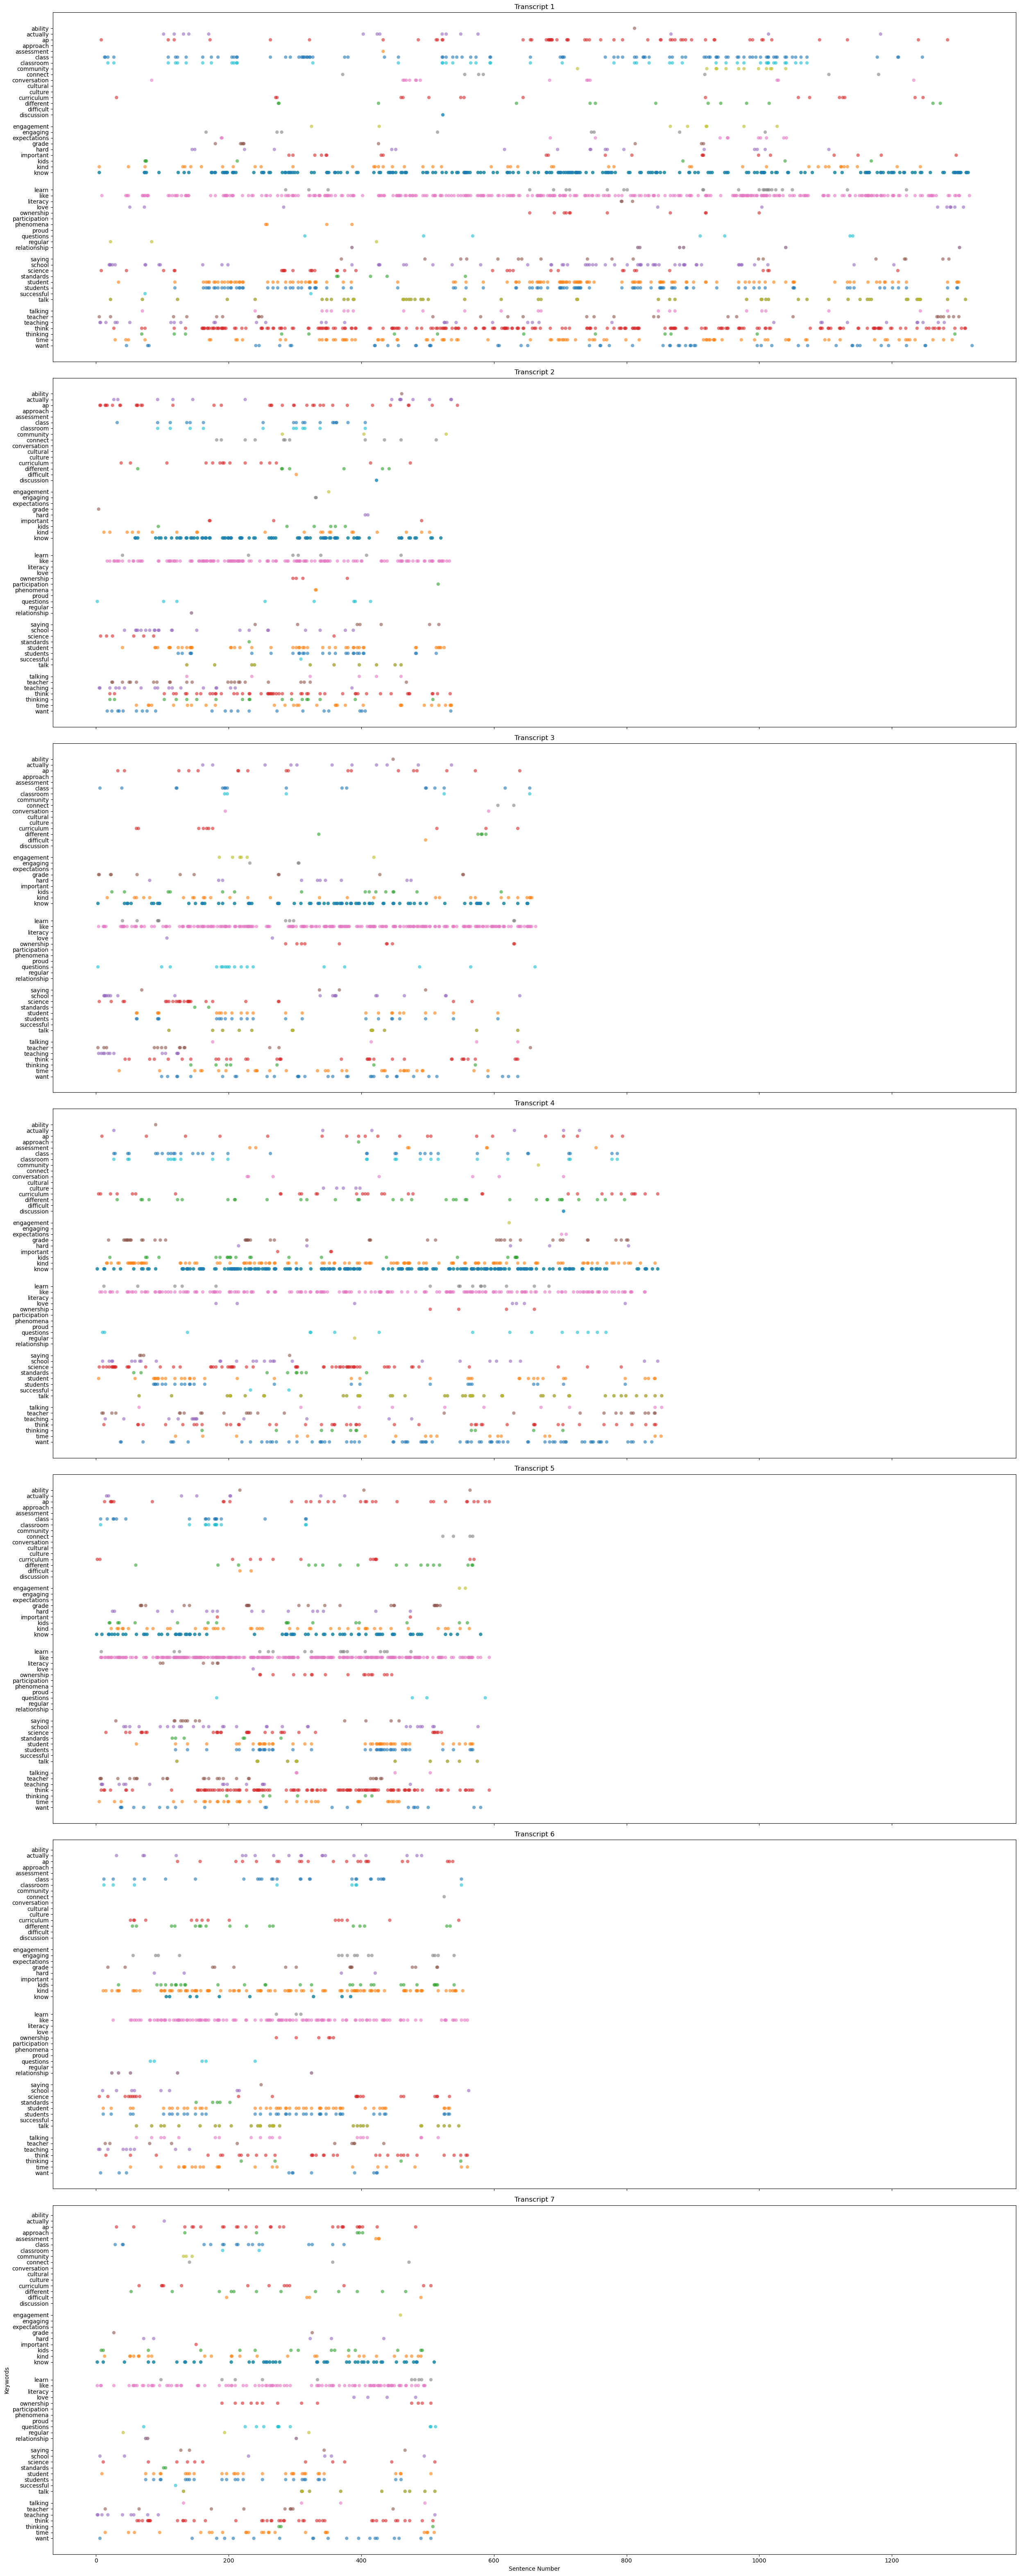

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example keywords to track
keywords = sorted(['students', "science", 'engagement', 'ability', 'community', 'talk',
            'culture', 'ownership', 'regular', 'successful', 'participation', 'expectations', 
            'ap', 'assessment', 'cultural', 'phenomena', 'important', 'know', 'standards', 'relationship',
            "engaging", 'literacy', 'relationship', 'kids', 'connect', 'student', 'classroom', 
            'teacher', 'teaching', 'school', 'class', 'curriculum', 'learn', 'approach', 'talking', 
            'discussion', 'love', 'proud', 'like', 'difficult', 'actually', 'know', 'questions', 'know',
            'think', 'want', 'kind','time', 'grade', 'thinking', 'different', 'talk', 'conversation', 
            'discussion', 'hard', 'saying'], reverse=True)

# Mapping keywords to numeric values for plotting
keyword_mapping = {keyword: i for i, keyword in enumerate(keywords)}

# Number of transcripts (corpora)
num_corpora = len(processed_transcripts)

# Create subplots for each transcript
fig, axes = plt.subplots(num_corpora, 1, figsize=(25, num_corpora*9), sharex=True)

# Convert axes to an array if it's not (happens when num_corpora is 1)
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

# Iterate over each transcript and plot keyword occurrences
for ax, (i, df) in zip(axes, enumerate(processed_transcripts)):
    ax.set_title(f"Transcript {i + 1}")
    
    # Get the sentence tokens from each transcript
    sentence_tokens = df['nltk_unprocessed_sentence_tokens'].explode().tolist()  # Flatten sentence tokens
    
    # Plot the occurrences of each keyword
    for keyword in keywords:
        occurrences = [(i + 1, j + 1) for j, sentence in enumerate(sentence_tokens) if keyword in sentence.lower()]
        sentence_nums = [occ[1] for occ in occurrences]
        
        y_values = np.full_like(sentence_nums, keyword_mapping[keyword], dtype=float)
        ax.scatter(sentence_nums, y_values, label=keyword, alpha=0.6, edgecolors='none')
    
    ax.set_yticks(list(keyword_mapping.values()))
    ax.set_yticklabels(list(keyword_mapping.keys()))

# Adjust layout
plt.xlabel('Sentence Number')
plt.ylabel('Keywords')

plt.tight_layout()

# Save the figure to an image file before displaying
plt.savefig('data/my_keyword_plots.png', bbox_inches='tight')

plt.show()


### 3.03 Combined

In [3]:
import plotly.graph_objects as go
import numpy as np

# Example keywords to track
keywords = ['students', "science", 'engagement', 'ability', 'community', 'talk',
            'culture', 'ownership', 'regular', 'successful', 'participation', 'expectations', 
            'ap', 'assessment', 'cultural', 'phenomena', 'important', 'know', 'standards', 'relationship',
            "engaging", 'literacy', 'relationship', 'kids', 'connect', 'student', 'classroom', 
            'teacher', 'teaching', 'school', 'class', 'curriculum', 'learn', 'approach', 'talking', 
            'discussion', 'love', 'proud', 'like', 'difficult', 'actually', 'know', 'questions', 'know',
            'think', 'want', 'kind', 'time', 'grade', 'thinking', 'different', 'talk', 'conversation', 
            'discussion', 'hard', 'saying']

# Map keywords to numeric values for plotting
keyword_mapping = {keyword: i for i, keyword in enumerate(keywords)}

# Create a figure with an increased height to better fit the number of keywords
fig = go.Figure()

# Process each transcript and plot keyword occurrences
for i, df in enumerate(processed_transcripts):
    transcript_name = f"Transcript {i + 1}"
    
    # Get sentence tokens from each transcript
    sentence_tokens = df['nltk_unprocessed_sentence_tokens'].explode().tolist()  # Flatten sentence tokens
    
    # Loop through keywords and plot occurrences in sentences
    for keyword in keywords:
        # Find occurrences of the keyword in the sentences
        occurrences = [(transcript_name, j + 1) for j, sentence in enumerate(sentence_tokens) if keyword in sentence.lower()]
        sentence_nums = [occ[1] for occ in occurrences if occ[0] == transcript_name]
        y_values = np.full_like(sentence_nums, keyword_mapping[keyword], dtype=float)

        # Adding traces for each keyword
        fig.add_trace(go.Scatter(x=sentence_nums, y=y_values, mode='markers', name=keyword,
                                 text=[f'Sentence: {num}' for num in sentence_nums],
                                 marker=dict(size=8, opacity=0.6)))

# Update layout with an appropriate height and labels
fig.update_layout(title='Keyword Occurrence Across Sentences in Multiple Transcripts',
                  xaxis_title='Sentence Number',
                  yaxis=dict(tickmode='array', tickvals=list(keyword_mapping.values()), ticktext=list(keyword_mapping.keys())),
                  legend_title='Keywords',
                  height=1200)  # Adjust height based on number of keywords

# Save the figure to an HTML file for interactive viewing
fig.write_html('data/my_interactive_plots.html')

# Show the figure
fig.show()



### 3.04 Side to side

In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Number of transcripts (corpora) to be displayed
num_corpora = len(processed_transcripts)

# Create subplots for each transcript
fig = make_subplots(rows=1, cols=num_corpora, subplot_titles=[f"Transcript {i + 1}" for i in range(num_corpora)])

# Example keywords to track, sorted for consistency across the plot
keywords = sorted(['students', "science", 'engagement', 'ability', 'community', 'talk',
            'culture', 'ownership', 'regular', 'successful', 'participation', 'expectations', 
            'ap', 'assessment', 'cultural', 'phenomena', 'important', 'know', 'standards', 
            'relationship', 'engaging', 'literacy', 'relationship', 'kids', 'connect', 
            'student', 'classroom', 'teacher', 'teaching', 'school', 'class', 'curriculum', 
            'learn', 'approach', 'talking', 'discussion', 'love', 'proud', 'like', 'difficult', 
            'actually', 'know', 'questions', 'think', 'want', 'kind', 'time', 'grade', 
            'thinking', 'different', 'talk', 'conversation', 'discussion', 'hard', 'saying'], reverse=True)

# Mapping keywords to numeric values for plotting
keyword_mapping = {keyword: i for i, keyword in enumerate(keywords)}

# Index for the current subplot
col_index = 1

# Loop through each transcript and plot keyword occurrences
for i, df in enumerate(processed_transcripts):
    transcript_name = f"Transcript {i + 1}"
    
    # Get sentence tokens from each transcript
    sentence_tokens = df['nltk_unprocessed_sentence_tokens'].explode().tolist()  # Flatten sentence tokens
    
    # Plot the occurrences of each keyword in the sentences
    for keyword in keywords:
        # Find occurrences of the keyword in the sentences
        occurrences = [(transcript_name, j + 1) for j, sentence in enumerate(sentence_tokens) if keyword in sentence.lower()]
        sentence_nums = [occ[1] for occ in occurrences]
        y_values = np.full_like(sentence_nums, keyword_mapping[keyword], dtype=float)

        # Add traces for each keyword to the respective subplot
        fig.add_trace(go.Scatter(x=sentence_nums, y=y_values, mode='markers', name=keyword,
                                 text=[f'Sentence: {num}' for num in sentence_nums],
                                 marker=dict(size=10, opacity=0.5)),  # Adjust marker size for visibility
                      row=1, col=col_index)

    col_index += 1  # Move to the next subplot for the next transcript

# Update layout to ensure all keywords are visible
fig.update_layout(
    title='Keyword Occurrence Across Sentences in Multiple Transcripts',
    xaxis_title='Sentence Number',
    yaxis=dict(
        tickmode='array',
        tickvals=list(keyword_mapping.values()),
        ticktext=list(keyword_mapping.keys())
    ),
    legend_title='Keywords',
    height=1200,  # Increase height to accommodate all keywords
    showlegend=True
)

# Save the figure to an HTML file for interactive viewing
fig.write_html('data/my_interactive_plots.html')

# Show the figure
fig.show()


### 3.05 Needs fixing

In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Number of transcripts (corpora) to be displayed
num_corpora = len(processed_transcripts)

# Create subplots for each transcript
fig = make_subplots(rows=1, cols=num_corpora, subplot_titles=[f"Transcript {i+1}" for i in range(num_corpora)])

# Example keywords to track, sorted for consistency across the plot
keywords = sorted(['students', "science", 'engagement', 'ability', 'community', 'talk',
            'culture', 'ownership', 'regular', 'successful', 'participation', 'expectations', 
            'ap', 'assessment', 'cultural', 'phenomena', 'important', 'know', 'standards', 
            'relationship', 'engaging', 'literacy', 'relationship', 'kids', 'connect', 
            'student', 'classroom', 'teacher', 'teaching', 'school', 'class', 'curriculum', 
            'learn', 'approach', 'talking', 'discussion', 'love', 'proud', 'like', 'difficult', 
            'actually', 'know', 'questions', 'think', 'want', 'kind', 'time', 'grade', 
            'thinking', 'different', 'talk', 'conversation', 'discussion', 'hard', 'saying'], reverse=True)

# Mapping keywords to numeric values for plotting
keyword_mapping = {keyword: i for i, keyword in enumerate(keywords)}

# Loop through each transcript and plot keyword occurrences
for i, df in enumerate(processed_transcripts):
    transcript_name = f"Transcript {i + 1}"
    
    # Get sentence tokens from each transcript
    sentence_tokens = df['nltk_unprocessed_sentence_tokens'].explode().tolist()  # Flatten sentence tokens
    
    # Plot the occurrences of each keyword in the sentences
    for keyword in keywords:
        # Find occurrences of the keyword in the sentences
        occurrences = [(transcript_name, j + 1) for j, sentence in enumerate(sentence_tokens) if keyword in sentence.lower()]
        sentence_nums = [occ[1] for occ in occurrences]
        y_values = np.full_like(sentence_nums, keyword_mapping[keyword], dtype=float)

        # Add traces for each keyword
        fig.add_trace(go.Scatter(x=sentence_nums, y=y_values, mode='markers',
                                 text=[f'{keyword} (Sentence: {num})' for num in sentence_nums],
                                 marker=dict(size=10, opacity=0.5),
                                 showlegend=False),  # This prevents adding each keyword to the legend multiple times
                      row=1, col=i+1)

# Update layout
fig.update_layout(
    title='Keyword Occurrence Across Sentences in Multiple Transcripts',
    xaxis_title='Sentence Number',
    yaxis=dict(
        tickmode='array',
        tickvals=list(keyword_mapping.values()),
        ticktext=list(keyword_mapping.keys())
    ),
    height=1200,  # Increase height to accommodate all keywords
)

# Save the figure to an HTML file for interactive viewing
fig.write_html('data/my_interactive_plots.html')

# Show the figure
fig.show()



## 4.00 Additional Resources

## Step 3: Topic Modeling and Semantic Similarities Across Transcriptions
Generating Sentence Embeddings for Each Transcription
We'll generate embeddings for each transcription and store them.

In [7]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load the sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Store embeddings and related info
embeddings_list = []
file_names = []

# Loop through each transcript DataFrame in processed_transcripts
for i, df in enumerate(processed_transcripts):
    # Join the cleaned text from each transcript
    text = ' '.join(df['cleaned_text'])  # Assuming cleaned text is stored in 'cleaned_text' column
    
    # Generate embeddings for the entire transcript text
    embedding = model.encode(text)
    
    # Append the embedding and source file name
    embeddings_list.append(embedding)
    
    # Assuming the transcript DataFrame has a 'source_file' column or use a placeholder like 'Transcript {i+1}'
    file_names.append(f"Transcript {i + 1}" if 'source_file' not in df.columns else df['source_file'].iloc[0])

# Convert embeddings and file names into a dictionary for further use
embedding_data = {
    'file_names': file_names,
    'embeddings': embeddings_list
}

# Example: Use embeddings_data for further analysis, e.g., comparing semantic similarity
print("Embeddings have been generated for each transcript.")



/opt/homebrew/Caskroom/miniforge/base/envs/nlp24-env/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)

/opt/homebrew/Caskroom/miniforge/base/envs/nlp24-env/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



Embeddings have been generated for each transcript.


## Comparing Transcriptions Using Semantic Similarity
We'll compute the cosine similarity between each pair of transcriptions.

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# Step 1: Load SentenceTransformer and generate embeddings (from previous code)
# Assuming embeddings_list and file_names have already been generated as shown in the previous code

# Step 2: Convert list of embeddings to a numpy array
embeddings_array = np.vstack(embeddings_list)

# Step 3: Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings_array)

# Step 4: Create a DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_matrix, index=file_names, columns=file_names)

# Step 5: Print or visualize the similarity matrix
print(similarity_df)

# Optional: Save the similarity matrix to a CSV file for further analysis
similarity_df.to_csv('data/transcript_similarity_matrix.csv')



              Transcript 1  Transcript 2  Transcript 3  Transcript 4  \
Transcript 1      1.000000      0.747239      0.680909      0.630633   
Transcript 2      0.747239      1.000000      0.678436      0.663380   
Transcript 3      0.680909      0.678436      1.000000      0.676200   
Transcript 4      0.630633      0.663380      0.676200      1.000000   
Transcript 5      0.650636      0.737392      0.705749      0.800672   
Transcript 6      0.690457      0.706265      0.679670      0.661172   
Transcript 7      0.639450      0.683704      0.730459      0.754923   

              Transcript 5  Transcript 6  Transcript 7  
Transcript 1      0.650636      0.690457      0.639450  
Transcript 2      0.737392      0.706265      0.683704  
Transcript 3      0.705749      0.679670      0.730459  
Transcript 4      0.800672      0.661172      0.754923  
Transcript 5      1.000000      0.701456      0.801993  
Transcript 6      0.701456      1.000000      0.721746  
Transcript 7      0.8019

## Visualizing the Similarity Matrix

# Topic Modeling on Individual Transcriptions
Using Latent Dirichlet Allocation (LDA)
First, you need to prepare the data for LDA:

In [9]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Function to perform LDA
def perform_lda(tokens_list, num_topics=5):
    # Create a dictionary representation of the documents
    dictionary = Dictionary(tokens_list)

    # Filter out extremes to limit the number of features
    dictionary.filter_extremes(no_below=1, no_above=0.5)

    # Create a bag-of-words representation of the documents
    corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]

    # Train the LDA model
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
    
    return lda, corpus, dictionary

# Step 1: Extract word tokens from the processed transcripts
tokens_list = []

for df in processed_transcripts:
    # Extract word tokens from each transcript and flatten them into a list
    tokens = df['nltk_unprocessed_word_tokens'].explode().tolist()
    
    # Add tokenized transcript to the list
    tokens_list.append(tokens)

# Step 2: Perform LDA on the extracted tokens
lda_model, corpus, dictionary = perform_lda(tokens_list, num_topics=5)

# Step 3: Print the topics discovered by the LDA model
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx + 1}: {topic}")


Topic 1: 0.004*"structure" + 0.004*"AP" + 0.003*"honestly" + 0.003*"course" + 0.003*"figuring" + 0.003*"expectations" + 0.003*"sixth" + 0.002*"cancer" + 0.002*"phone" + 0.002*"optimistic"
Topic 2: 0.003*"sixth" + 0.003*"Mississippi" + 0.003*"engineering" + 0.003*"wanting" + 0.002*"AP" + 0.002*"special" + 0.002*"notes" + 0.002*"principles" + 0.002*"Ms" + 0.002*"cancer"
Topic 3: 0.004*"sixth" + 0.003*"AP" + 0.003*"wanting" + 0.003*"structure" + 0.002*"conversation" + 0.002*"honestly" + 0.002*"planet" + 0.002*"engineering" + 0.002*"world" + 0.002*"expectations"
Topic 4: 0.005*"AP" + 0.003*"car" + 0.003*"waves" + 0.003*"motivation" + 0.003*"engineering" + 0.002*"circus" + 0.002*"structure" + 0.002*"grading" + 0.002*"phone" + 0.002*"honestly"
Topic 5: 0.004*"sixth" + 0.004*"AP" + 0.003*"planet" + 0.002*"honestly" + 0.002*"conversation" + 0.002*"engineering" + 0.002*"literally" + 0.002*"structure" + 0.002*"guys" + 0.002*"wanting"
